# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [122]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import time

In [123]:
df = pd.read_csv('/datasets/autos.csv')

In [124]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [126]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [127]:
df['RegistrationMonth'].value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

### Проверим дубликаты и лишние столбцы

In [128]:
display(df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()
# дубликатов всего 4, удалю их

4

0

In [129]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

### Проверим пропуски

In [130]:
# проверим все пропуски
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
dtype: int64

In [131]:
display(df['VehicleType'].unique())
df['VehicleType'].value_counts()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [132]:
# пропуски в VehicleType заменил на other, так как точно восстановить не возможно
df['VehicleType'] = df['VehicleType'].fillna('other')

In [133]:
display(df['Gearbox'].unique())
df['Gearbox'].value_counts()

array(['manual', 'auto', nan], dtype=object)

manual    268249
auto       66283
Name: Gearbox, dtype: int64

In [134]:
# пропуски заменил на other, так как точно восстановить не возможно
df['Gearbox'] = df['Gearbox'].fillna('other')

In [135]:
display(df['Model'].unique())
df['Model'].value_counts()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

In [136]:
# пропуски в Model заменил на other, так как точно восстановить не возможно
df['Model'] = df['Model'].fillna('other')

In [137]:
display(df['FuelType'].unique())
df['FuelType'].value_counts()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [138]:
# пропуски в FuelType заменил на other, так как точно восстановить не возможно
df['FuelType'] = df['FuelType'].fillna('other')

In [139]:
display(df['NotRepaired'].unique())
df['NotRepaired'].value_counts()

array([nan, 'yes', 'no'], dtype=object)

no     247158
yes     36053
Name: NotRepaired, dtype: int64

In [140]:
# пропуски в FuelType заменил на unknown, так как точно восстановить не возможно
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

In [141]:
# проверим остались ли пропуски
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

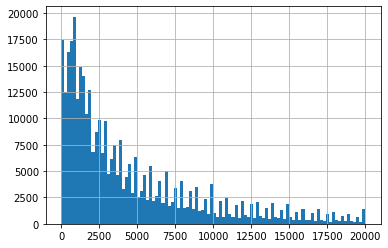

In [142]:
# проверим столбец Price на выбросы
display(df['Price'].describe())
display(df['Price'].value_counts())
df['Price'].hist(bins=100);

In [143]:
# объявления дешевле 1000 не будем использовать при обучение модели
df = df.loc[df['Price']> 1000]

count    266391.000000
mean       2004.785623
std          56.597238
min        1000.000000
25%        2001.000000
50%        2005.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

2005    20315
2006    19427
2004    18550
2003    17742
2007    16865
        ...  
1946        1
1949        1
8888        1
7100        1
2800        1
Name: RegistrationYear, Length: 122, dtype: int64

<AxesSubplot:>

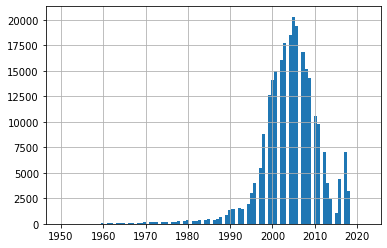

In [144]:
# проверим столбец RegistrationYear на выбросы 
display(df['RegistrationYear'].describe())
display(df['RegistrationYear'].value_counts())
df['RegistrationYear'].hist(bins=100, range=(1950, 2022))

In [145]:
# удалю год регистрации авто младше 1960 и старше 2020
df = df.loc[(df['RegistrationYear'] >= 1960) & (df['RegistrationYear'] <= 2020)]

count    266116.000000
mean        122.111760
std         193.772912
min           0.000000
25%          77.000000
50%         116.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

0        20067
75       14592
150      12530
140      12230
116       9778
         ...  
421          1
10912        1
1701         1
20000        1
428          1
Name: Power, Length: 622, dtype: int64

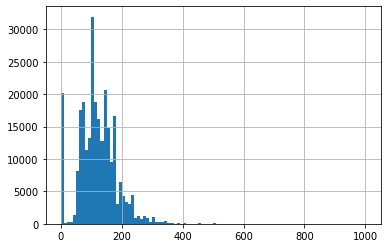

In [146]:
# проверим столбец Price на выбросы
display(df['Power'].describe())
display(df['Power'].value_counts())
df['Power'].hist(bins=100, range=(0, 1000));

In [147]:
# удалю мощность авто меньше 20 и больше 600
df = df.loc[(df['Power'] >= 20) & (df['Power'] <= 600)]

### Вывод:

Загрузил данные, удалил дубликаты, заполнил пропуски.

## Обучение моделей

In [148]:
target = df['Price']
features = df.drop('Price', axis=1)

In [149]:
# преобразуем категориальные признаки в численные методом One-hot-encoding для определенных моделей
features_ohe = pd.get_dummies(features, drop_first=True)
features_ohe.shape

(245500, 308)

In [150]:
# отделил обучающаую выборку, взял 80%
features_train, features_rest, target_train, target_rest = train_test_split(features, target, test_size=0.20, random_state=12345)

# отделил валидационную и тестовую выборки 50/50
features_test, features_valid, target_test, target_valid = train_test_split(features_rest, target_rest, test_size=0.5, random_state=12345)


In [151]:
display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)

(196400, 10)

(24550, 10)

(24550, 10)

In [152]:
# отделил обучающаую выборку кодированную, взял 80%
features_train_ohe, features_rest_ohe, target_train, target_rest = train_test_split(features_ohe, target, test_size=0.20, random_state=12345)

# отделил валидационную и тестовую выборки 50/50
features_test_ohe, features_valid_ohe, target_test, target_valid = train_test_split(features_rest_ohe, target_rest, test_size=0.5, random_state=12345)


In [153]:
display(features_train_ohe.shape)
display(features_test_ohe.shape)
display(features_valid_ohe.shape)

(196400, 308)

(24550, 308)

(24550, 308)

In [154]:
# словари с результатами RMSE и времени выполнения по разным моделям
best = {}  # результаты RMSE
time_fit_all = {} # результаты обучения
time_predict_all = {} # результаты предсказания

In [155]:
%%time
start = time.time()

model = LinearRegression()
model.fit(features_train_ohe, target_train)

f = time.time()
time_fit = f - start

predicted_valid = model.predict(features_valid_ohe)

p= time.time()
time_predict = p - f

rmse = mean_squared_error(target_valid, predicted_valid)** 0.5
print(f"RMSE на валидационной выборке = {rmse:.2f}")
predicted_test = model.predict(features_test_ohe)
rmse = mean_squared_error(target_test, predicted_test)** 0.5
print(f"RMSE на тестовой выборке = {rmse:.2f}")

print(f'\nВремя выполнения обучения {time_fit:.2f} секунд')
print(f'Время выполнения предсказания {time_predict:.2f} секунд')

best['LinearRegression'] = rmse
time_fit_all['LinearRegression'] = time_fit
time_predict_all['LinearRegression'] = time_predict

RMSE на валидационной выборке = 2700.44
RMSE на тестовой выборке = 2697.25

Время выполнения обучения 47.20 секунд
Время выполнения предсказания 0.10 секунд
CPU times: user 22.8 s, sys: 24.7 s, total: 47.4 s
Wall time: 47.5 s


In [156]:
best_rmse = 7000
best_n_estimators = 0
for i in range(1, 100, 10):
    model = DecisionTreeRegressor(random_state=12345, max_depth=i)
    model.fit(features_train_ohe, target_train)
    predicted_valid = model.predict(features_valid_ohe)
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    if rmse < best_rmse:
        best_rmse = rmse
        best_n_estimators = i
print("Лучший mse:", best_rmse)
print("Лучший n_estimators:", best_n_estimators)

Лучший mse: 2032.2792986648858
Лучший n_estimators: 21


In [157]:
# Лучший показатель был при max_depth=21, его буду использовать дальше

start = time.time()

model = DecisionTreeRegressor(random_state=12345, max_depth=21)
model.fit(features_train_ohe, target_train)

f = time.time()
time_fit = f - start

predicted_valid = model.predict(features_valid_ohe)

p= time.time()
time_predict = p - f

rmse = mean_squared_error(target_valid, predicted_valid)** 0.5
print(f"RMSE на валидационной выборке = {rmse:.2f}")
predicted_test = model.predict(features_test_ohe)
rmse = mean_squared_error(target_test, predicted_test)** 0.5
print(f"RMSE на тестовой выборке = {rmse:.2f}")

print(f'\nВремя выполнения обучения {time_fit:.2f} секунд')
print(f'Время выполнения предсказания {time_predict:.2f} секунд')

best['DecisionTreeRegressor'] = rmse
time_fit_all['DecisionTreeRegressor'] = time_fit
time_predict_all['DecisionTreeRegressor'] = time_predict

RMSE на валидационной выборке = 2032.28
RMSE на тестовой выборке = 1999.62

Время выполнения обучения 6.52 секунд
Время выполнения предсказания 0.04 секунд


In [158]:
# RandomForestRegressor работает очень долго
start = time.time()
model = RandomForestRegressor(random_state=12345)
model.fit(features_train_ohe, target_train)

f = time.time()
time_fit = f - start

predicted_valid = model.predict(features_valid_ohe)

p= time.time()
time_predict = p - f

rmse = mean_squared_error(target_valid, predicted_valid)** 0.5
print(f"RMSE на валидационной выборке = {rmse:.2f}")
predicted_test = model.predict(features_test_ohe)
rmse = mean_squared_error(target_test, predicted_test)** 0.5
print(f"RMSE на тестовой выборке = {rmse:.2f}")

print(f'\nВремя выполнения обучения {time_fit:.2f} секунд')
print(f'Время выполнения предсказания {time_predict:.2f} секунд')

best['RandomForestRegressor'] = rmse
time_fit_all['RandomForestRegressor'] = time_fit
time_predict_all['RandomForestRegressor'] = time_predict

RMSE на валидационной выборке = 1677.18
RMSE на тестовой выборке = 1642.14

Время выполнения обучения 469.51 секунд
Время выполнения предсказания 1.67 секунд


In [159]:
%%time
start = time.time()

cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
 
model = CatBoostRegressor(cat_features = cat_features, iterations=500)
model.fit(features_train, target_train, cat_features=cat_features, verbose=50)

f = time.time()
time_fit = f - start

predicted_valid = model.predict(features_valid)

p= time.time()
time_predict = p - f

rmse = mean_squared_error(target_valid, predicted_valid)** 0.5
print(f"RMSE на валидационной выборке = {rmse:.2f}")
predicted_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test)** 0.5
print(f"RMSE на тестовой выборке = {rmse:.2f}")

print(f'\nВремя выполнения обучения {time_fit:.2f} секунд')
print(f'Время выполнения предсказания {time_predict:.2f} секунд')

best['CatBoostRegressor'] = rmse
time_fit_all['CatBoostRegressor'] = time_fit
time_predict_all['CatBoostRegressor'] = time_predict

Learning rate set to 0.165666
0:	learn: 4104.1212760	total: 300ms	remaining: 2m 29s
50:	learn: 1879.7777450	total: 12.3s	remaining: 1m 48s
100:	learn: 1788.6433520	total: 24.9s	remaining: 1m 38s
150:	learn: 1746.9366705	total: 36.6s	remaining: 1m 24s
200:	learn: 1720.8892114	total: 48.8s	remaining: 1m 12s
250:	learn: 1701.0029628	total: 1m 1s	remaining: 1m
300:	learn: 1685.2072455	total: 1m 15s	remaining: 49.8s
350:	learn: 1671.2055345	total: 1m 29s	remaining: 38.2s
400:	learn: 1660.0325091	total: 1m 44s	remaining: 25.7s
450:	learn: 1649.4977138	total: 1m 59s	remaining: 13s
499:	learn: 1639.8021603	total: 2m 13s	remaining: 0us
RMSE на валидационной выборке = 1708.83
RMSE на тестовой выборке = 1697.33

Время выполнения обучения 136.22 секунд
Время выполнения предсказания 0.17 секунд
CPU times: user 2min 14s, sys: 687 ms, total: 2min 15s
Wall time: 2min 16s


In [160]:
%%time
start = time.time()

model = LGBMRegressor()
model.fit(features_train_ohe, target_train)

f = time.time()
time_fit = f - start

probabilities_valid = model.predict(features_valid_ohe)

p= time.time()
time_predict = p - f

rmse = mean_squared_error(target_valid, predicted_valid)** 0.5
print(f"RMSE на валидационной выборке = {rmse:.2f}")
predicted_test = model.predict(features_test_ohe)
rmse = mean_squared_error(target_test, predicted_test)** 0.5
print(f"RMSE на тестовой выборке = {rmse:.2f}")

print(f'\nВремя выполнения обучения {time_fit:.2f} секунд')
print(f'Время выполнения предсказания {time_predict:.2f} секунд')

best['LGBMRegressor'] = rmse
time_fit_all['LGBMRegressor'] = time_fit
time_predict_all['LGBMRegressor'] = time_predict

RMSE на валидационной выборке = 1708.83
RMSE на тестовой выборке = 1780.26

Время выполнения обучения 385.97 секунд
Время выполнения предсказания 0.33 секунд
CPU times: user 6min 21s, sys: 2.95 s, total: 6min 24s
Wall time: 6min 26s


### Вывод

После исследования моделей наилучший показатель у модели RandomForestRegressor RMSE = 1642.14

## Анализ моделей

In [161]:
for model, index in sorted(best.items(), key=lambda item: item[1]):
    print(f'Модель {model} - RMSE = {index:.2f}')

Модель RandomForestRegressor - RMSE = 1642.14
Модель CatBoostRegressor - RMSE = 1697.33
Модель LGBMRegressor - RMSE = 1780.26
Модель DecisionTreeRegressor - RMSE = 1999.62
Модель LinearRegression - RMSE = 2697.25


In [162]:
for model, index in sorted(time_fit_all.items(), key=lambda item: item[1]):
    print(f'Модель {model} - время выполнения обучения = {index:.2f} секунд')

Модель DecisionTreeRegressor - время выполнения обучения = 6.52 секунд
Модель LinearRegression - время выполнения обучения = 47.20 секунд
Модель CatBoostRegressor - время выполнения обучения = 136.22 секунд
Модель LGBMRegressor - время выполнения обучения = 385.97 секунд
Модель RandomForestRegressor - время выполнения обучения = 469.51 секунд


In [163]:
for model, index in sorted(time_predict_all.items(), key=lambda item: item[1]):
    print(f'Модель {model} - время предсказания = {index:.2f} секунд')

Модель DecisionTreeRegressor - время предсказания = 0.04 секунд
Модель LinearRegression - время предсказания = 0.10 секунд
Модель CatBoostRegressor - время предсказания = 0.17 секунд
Модель LGBMRegressor - время предсказания = 0.33 секунд
Модель RandomForestRegressor - время предсказания = 1.67 секунд


## Вывод

Модель RandomForestRegressor показала лучший результат RMSE = 1642.14. Самое быстрое  время обучения у модели DecisionTreeRegressor = 6.52 секунд при max_depth=21. Самое быстрое время предсказания у модели DecisionTreeRegressor 0.04 секунд. 
На тестовой выборке результаты сравнимы с валидационной. 
 